## Using masked array with Hi-C map

Large Hi-C map data contains missing values. During analysis, sometimes we need to ignore these values. [numpy.ma module](http://docs.scipy.org/doc/numpy/reference/maskedarray.generic.html) can be used to perform mathematical operations after masking these missing values.

***

**At first, we import modules:**

* [gcMapExplorer.ccmap](../apidoc/ccmap.html) for loading `.ccmap` files
* [numpy](http://docs.scipy.org/doc/numpy/reference/routines.html) for array operations
* [numpy.ma](http://docs.scipy.org/doc/numpy/reference/maskedarray.generic.html) for masked array module
* [scipy.stats.mstats](http://docs.scipy.org/doc/scipy/reference/stats.mstats.html) for correlation calculation using masked array

In [1]:
import gcMapExplorer.lib as gmlib
import numpy as np
import os
from numpy import ma
from scipy import stats

import matplotlib.pyplot as plt

# To show inline plots
%matplotlib inline
plt.style.use('ggplot')              # Theme for plotting

***

#### To calculate correlation between Hi-C maps

**Load two Hi-C data**

In [2]:
ccmapOne = gmlib.ccmap.load_ccmap('cmaps/CooMatrix/chr15_100kb_RawObserved.ccmap')
ccmapOne.make_readable()

ccmapTwo = gmlib.ccmap.load_ccmap('normalized/chr15_100kb_normKR.ccmap')
ccmapTwo.make_readable()

**Determine smallest shape**

Matrix size can be different, therefore smallest size is determined to calculate element-wise correlation.

In [3]:
if ccmapOne.shape[0] <= ccmapTwo.shape[0]:
    smallest_shape = ccmapOne.shape[0]
else:
    smallest_shape = ccmapTwo.shape[0]

**Generate masks**

* At first, generate mask from two matrices sepratealy, and then combine it.

* Also, use slicing operations to derive subset of matrix with smallest shape.

* During masking, lower-triangular part is also masked with diagonal offset of five. Because the values at Hi-C map diagnoal is usually large, correlation could be high due to these large values. Moreover, we are usually intereseted in off-diagonal regions of the Hi-C maps.

In [4]:
m1 = ccmapOne.matrix[:smallest_shape, :smallest_shape] <= ccmapOne.minvalue   # Mask all minimum values
m2 = ccmapTwo.matrix[:smallest_shape, :smallest_shape] <= ccmapTwo.minvalue   # Mask all minimum values
mask = ( m1 & m2 )                              # Combine both masks
mask[np.tril_indices_from(mask, k=5)] = True    # Also, Mask lower-triangle of matrix with five diagonal offset

**Generate masked matrix**

Now, using `numpy.ma` module, generate masked matrices 

In [5]:
maskedMatrixOne = ma.array(ccmapOne.matrix[:smallest_shape, :smallest_shape], mask=mask)
maksedMatrixTwo = ma.array(ccmapTwo.matrix[:smallest_shape, :smallest_shape], mask=mask)

**Calculate correlation coefficiant**

* Pearson correlation coefficiant using [scipy.stats.mstats.pearsonr](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.pearsonr.html#scipy.stats.mstats.pearsonr)

In [6]:
corr, pvalue = stats.pearsonr(maskedMatrixOne.compressed(), maksedMatrixTwo.compressed())

print('Pearson Correlation: ', corr)

corr, pvalue = stats.spearmanr(maskedMatrixOne.compressed(), maksedMatrixTwo.compressed())

print('Spearman Correlation: ', corr)

Pearson Correlation:  0.580994
Spearman Correlation:  0.837034386661


#### Crorrelation using gcMapExplorer.lib.cmstats module

Shown above is a simple step-by-step example to calculate correlation-coefficiant using masked array.
However, above method may fail in case of huge matrices. Therefore, use the implemented
function `gcMapExplorer.cmstats.correlateCMaps` function 

In [7]:
corr, pvalue = gmlib.cmstats.correlateCMaps(ccmapOne, ccmapTwo, diagonal_offset=5)

print('Pearson Correlation: ', corr)

corr, pvalue = gmlib.cmstats.correlateCMaps(ccmapOne, ccmapTwo, corrType='spearman', diagonal_offset=5)
print('Spearman Correlation: ', corr)

Pearson Correlation:  0.580994
Spearman Correlation:  0.837035735987


Both above shown step-by-step example and implemented functions yielded similar correlation values.

#### Block-wise Crorrelation


To identify local difference between two maps, block-wise coorelation could be more helpful.
A block is created and slided along the diagonal, and for each new position, correlation is calculated. 

In [8]:
# Pearson correlation
pearson, p_centers = gmlib.cmstats.correlateCMaps(ccmapOne, ccmapTwo, diagonal_offset=2, blockSize='1mb', 
                                                 slideStepSize=1, outFile='pearson.txt', workDir=os.getcwd())


# Spearman correlation
spearman, s_centers = gmlib.cmstats.correlateCMaps(ccmapOne, ccmapTwo, corrType='spearman', diagonal_offset=2, 
                                                     blockSize='1mb', slideStepSize=1, outFile='spearman.txt',
                                                     workDir=os.getcwd())

INFO:correlateCMaps: Block-wise correlation with b] block-size
INFO:correlateCMaps: Number of Blocks: 102 
INFO:correlateCMaps: Size of each Block in bins: 10 
INFO:correlateCMaps: Number of Overlapping bins between sliding blocks:  9
INFO:correlateCMaps: Block-wise correlation with b] block-size
INFO:correlateCMaps: Number of Blocks: 102 
INFO:correlateCMaps: Size of each Block in bins: 10 
INFO:correlateCMaps: Number of Overlapping bins between sliding blocks:  9


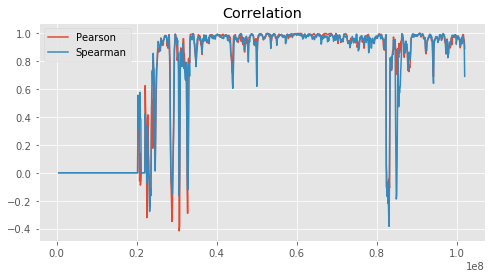

In [9]:
# Plot the values for visual representations
fig = plt.figure(figsize=(8,4))                               # Figure size

ax = fig.add_subplot(1,1,1)                                   # Axes first plot
ax.set_title('Correlation')                                   # Title first plot

ax.plot(p_centers, pearson, label='Pearson')                  # Plot for Pearson correlation
ax.plot(s_centers, spearman, label='Spearman')                # Plot for Spearman correlation

ax.get_xaxis().get_major_formatter().set_useOffset(False)     # Prevent ticks auto-formatting

plt.legend(loc=2)

plt.show()

***

### Calculating correlation from gcmap

Correlation between maps present in two gcmap files could be readily calculated as follows. Below is the example where at first correlation between raw and KR normalized maps are calculated. Further below, correlation between raw and IC maps are calculated.

In [10]:
gcMapOne = 'cmaps/CooMatrix/rawObserved_100kb.gcmap'
gcMapTwo = 'normalized/normKR_100kb.gcmap'
gcMapThree = 'normalized/normIC_100kb.gcmap'

mapList, corrsKR, pvaluesKR = gmlib.cmstats.correlateGCMaps(gcMapOne, gcMapTwo)
mapList, corrsIC, pvaluesIC = gmlib.cmstats.correlateGCMaps(gcMapOne, gcMapThree)

print('Pearson Correlation Raw vs KR/IC normalized')
print('============================================')
print('\nChromosome     Corr Raw-KR     Corr Raw-IC')
print('--------------------------------------------------------')
for i in range(len(mapList)):
    print('{0:5} {1:16.5} {2:15.5}'.format( mapList[i], corrsKR[i], corrsIC[i]))
print('--------------------------------------------------------')

INFO:correlateGCMaps: Performing calculation for chr1 ...
INFO:correlateGCMaps:     Finished calculation for chr1 ...

INFO:correlateGCMaps: Performing calculation for chr5 ...
INFO:correlateGCMaps:     Finished calculation for chr5 ...

INFO:correlateGCMaps: Performing calculation for chr15 ...
INFO:correlateGCMaps:     Finished calculation for chr15 ...

INFO:correlateGCMaps: Performing calculation for chr20 ...
INFO:correlateGCMaps:     Finished calculation for chr20 ...

INFO:correlateGCMaps: Performing calculation for chr21 ...
INFO:correlateGCMaps:     Finished calculation for chr21 ...

INFO:correlateGCMaps: Performing calculation for chr22 ...
INFO:correlateGCMaps:     Finished calculation for chr22 ...

INFO:correlateGCMaps: Performing calculation for chr1 ...
INFO:correlateGCMaps:     Finished calculation for chr1 ...

INFO:correlateGCMaps: Performing calculation for chr5 ...
INFO:correlateGCMaps:     Finished calculation for chr5 ...

INFO:correlateGCMaps: Performing calcula

Pearson Correlation Raw vs KR/IC normalized

Chromosome     Corr Raw-KR     Corr Raw-IC
--------------------------------------------------------
chr1             0.729         0.72935
chr5           0.77334         0.77344
chr15           0.7977          0.7977
chr20          0.96336         0.96336
chr21          0.82557         0.82557
chr22          0.89011         0.89011
--------------------------------------------------------


In [11]:
gcMapOne = 'cmaps/CooMatrix/rawObserved_100kb.gcmap'
gcMapTwo = 'normalized/normKR_100kb.gcmap'
gcMapThree = 'normalized/normIC_100kb.gcmap'

mapList, corrsKR, pvaluesKR = gmlib.cmstats.correlateGCMaps(gcMapOne, gcMapTwo, corrType='spearman')
mapList, corrsIC, pvaluesIC = gmlib.cmstats.correlateGCMaps(gcMapOne, gcMapThree, corrType='spearman')

print('Spearman Correlation Raw vs KR/IC normalized')
print('============================================')
print('\nChromosome     Corr Raw-KR     Corr Raw-IC')
print('--------------------------------------------------------')
for i in range(len(mapList)):
    print('{0:5} {1:16.5} {2:15.5}'.format( mapList[i], corrsKR[i], corrsIC[i]))
print('--------------------------------------------------------')

INFO:correlateGCMaps: Performing calculation for chr1 ...
INFO:correlateGCMaps:     Finished calculation for chr1 ...

INFO:correlateGCMaps: Performing calculation for chr5 ...
INFO:correlateGCMaps:     Finished calculation for chr5 ...

INFO:correlateGCMaps: Performing calculation for chr15 ...
INFO:correlateGCMaps:     Finished calculation for chr15 ...

INFO:correlateGCMaps: Performing calculation for chr20 ...
INFO:correlateGCMaps:     Finished calculation for chr20 ...

INFO:correlateGCMaps: Performing calculation for chr21 ...
INFO:correlateGCMaps:     Finished calculation for chr21 ...

INFO:correlateGCMaps: Performing calculation for chr22 ...
INFO:correlateGCMaps:     Finished calculation for chr22 ...

INFO:correlateGCMaps: Performing calculation for chr1 ...
INFO:correlateGCMaps:     Finished calculation for chr1 ...

INFO:correlateGCMaps: Performing calculation for chr5 ...
INFO:correlateGCMaps:     Finished calculation for chr5 ...

INFO:correlateGCMaps: Performing calcula

Spearman Correlation Raw vs KR/IC normalized

Chromosome     Corr Raw-KR     Corr Raw-IC
--------------------------------------------------------
chr1           0.91239         0.91239
chr5           0.94794         0.94794
chr15          0.83996         0.83996
chr20           0.9446          0.9446
chr21          0.86788         0.86788
chr22          0.82516         0.82516
--------------------------------------------------------
